# 1. transforms

In [1]:
import cv2
import torch
import albumentations as A
import matplotlib.pyplot as plt
import torchvision.transforms as v1
from torchvision.transforms import v2
from PIL import Image

shape: (1500, 1000, 3)
type: <class 'numpy.ndarray'>
dtype: uint8


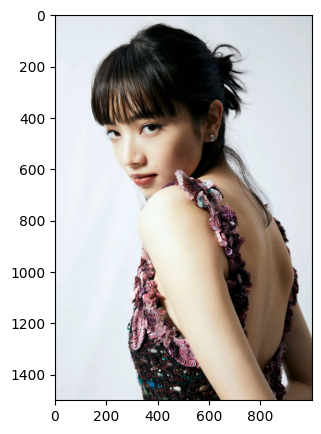

In [2]:
numpy_image = cv2.imread("./figure/nana.jpg")
numpy_image = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)
print(f"shape: {numpy_image.shape}")
print(f"type: {type(numpy_image)}")
print(f"dtype: {numpy_image.dtype}")

plt.figure(figsize=(10, 5))
plt.imshow(Image.fromarray(numpy_image))
plt.show()

In [3]:
def compare_images(original, transformed):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.axis("off")
    plt.title("Original")
    plt.subplot(1, 2, 2)
    plt.imshow(transformed)
    plt.axis("off")
    plt.title("Transformed")
    plt.show()

## 1.1 [torchvision.transforms](https://pytorch.org/vision/0.14/)

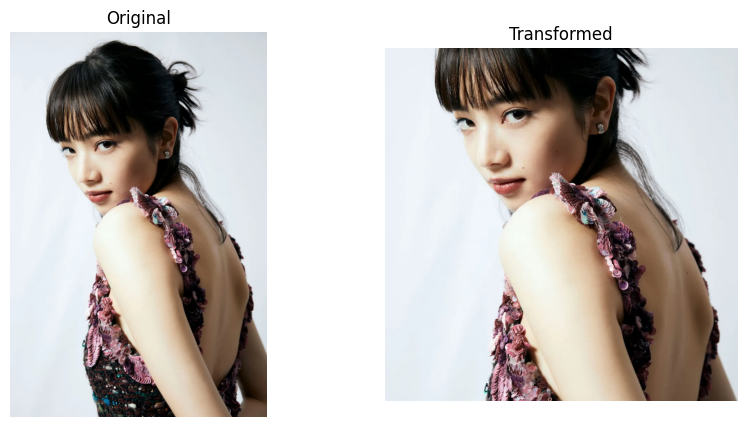

In [4]:
transform_v1 = v1.Compose([
    v1.CenterCrop(1000),
])

transformed_v1_image = transform_v1(Image.fromarray(numpy_image))
compare_images(Image.fromarray(numpy_image), transformed_v1_image)

## 1.2 [torchvision.transforms.v2](https://pytorch.org/vision/0.20/transforms.html)

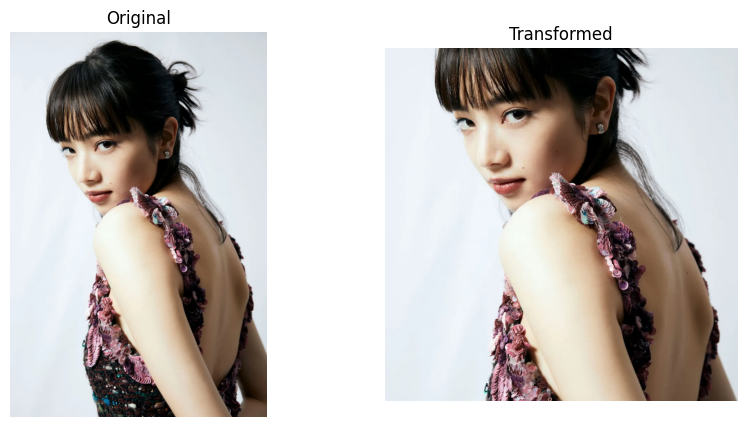

In [5]:
transform_v2 = v2.Compose([
    v2.CenterCrop(1000),
])

transformed_v2_image = transform_v2(Image.fromarray(numpy_image))
compare_images(Image.fromarray(numpy_image), transformed_v2_image)

## 1.3 [albumentations](https://albumentations.ai/docs/getting_started/image_augmentation/)

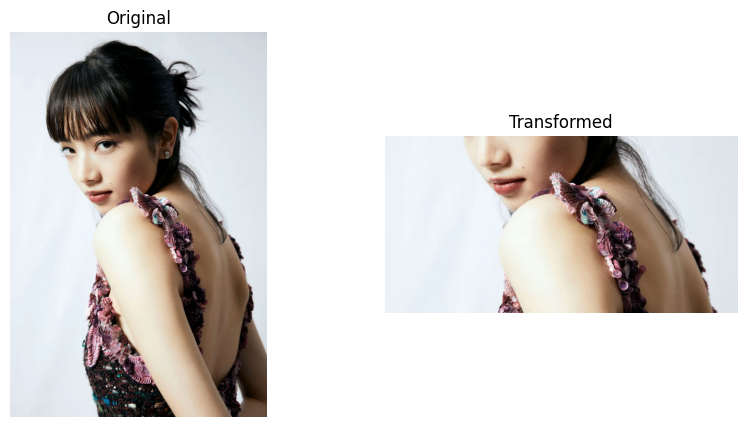

In [6]:
transform_A = A.Compose([
    A.CenterCrop(width=1000, height=500),
])

transformed_A_image = transform_A(image=numpy_image)
compare_images(Image.fromarray(numpy_image), Image.fromarray(transformed_A_image['image']))

## 1.4 custom

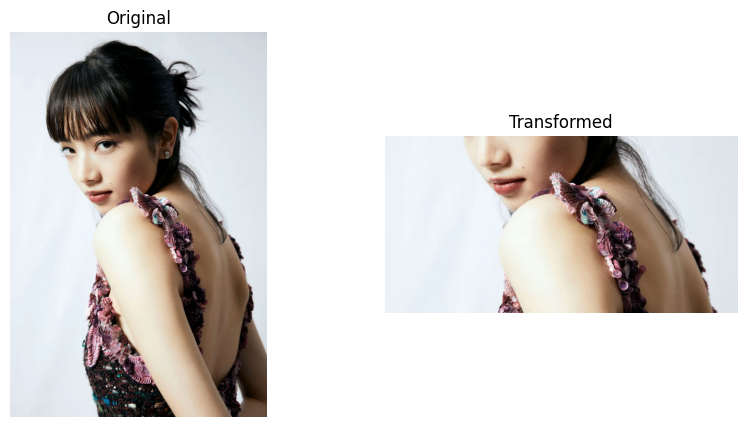

In [7]:
def center_crop(numpy_image, crop_width, crop_height):
    img_height, img_width = numpy_image.shape[:2]

    start_x = (img_width - crop_width) // 2
    start_y = (img_height - crop_height) // 2

    cropped_image = numpy_image[start_y:start_y + crop_height, start_x:start_x + crop_width]

    return cropped_image


crop_width, crop_height = 1000, 500
cropped_image = center_crop(numpy_image, crop_width, crop_height)

compare_images(Image.fromarray(numpy_image), Image.fromarray(cropped_image))

## 1.5 choice

In [8]:
transform_v2 = v2.Compose([
    v2.CenterCrop(300),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=False),
])

# 2. Dataset

## 2.1 [torchvision.datasets](https://pytorch.org/vision/0.20/datasets.html#built-in-datasets)

In [9]:
import os
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import Dataset

### 2.1.1 with transforms

In [10]:
mnist_dataset_with_transforms = MNIST(root="./data", train=True, transform=transform_v2, target_transform=None, download=False)

print(f"type: {mnist_dataset_with_transforms}")

transformed_image, transformed_label = mnist_dataset_with_transforms.__getitem__(0)

print(f"transformed_image type: {type(transformed_image)}")
print(f"transformed_image shape: {transformed_image.shape}")
print(f"transformed_label type: {type(transformed_label)}")
print(f"transformed_label: {transformed_label}")

type: Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
                 CenterCrop(size=(300, 300))
                 ToImage()
                 ToDtype(scale=False)
           )
transformed_image type: <class 'torchvision.tv_tensors._image.Image'>
transformed_image shape: torch.Size([1, 300, 300])
transformed_label type: <class 'int'>
transformed_label: 5


### 2.1.2 without transforms

In [11]:
mnist_dataset_without_transforms = MNIST(root="./data", train=True, transform=None, target_transform=None, download=False)

print(f"type: {mnist_dataset_without_transforms}")

image, label = mnist_dataset_without_transforms.__getitem__(0)

print(f"image type: {type(image)}")
print(f"image shape: {np.array(image).shape}")
print(f"label type: {type(label)}")
print(f"label: {label}")

type: Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
image type: <class 'PIL.Image.Image'>
image shape: (28, 28)
label type: <class 'int'>
label: 5


In [12]:
def tensor_to_pil(image_tensor):
    image_np = image_tensor.numpy()
    
    if image_np.shape[0] == 1:
        image_np = image_np.squeeze(0)
    else:
        image_np = image_np.transpose(1, 2, 0)

    return Image.fromarray(image_np.astype("uint8"))

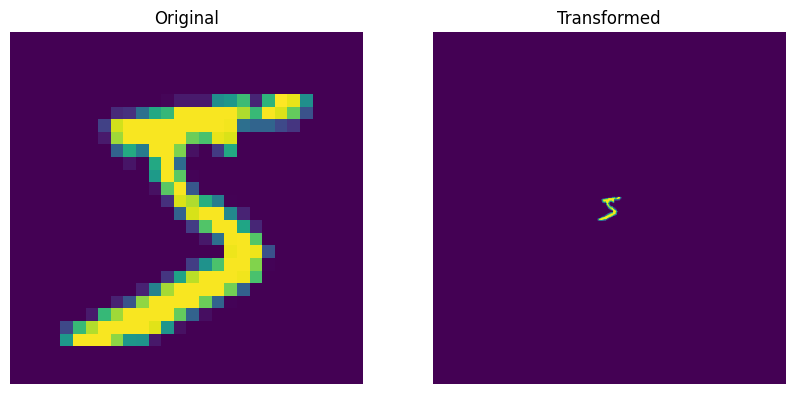

In [13]:
compare_images(image, tensor_to_pil(transformed_image))

## 2.2 [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)

In [14]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, label, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.label = label
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        file_name = os.listdir(self.image_dir)[idx]
        image_path = os.path.join(self.image_dir, file_name)

        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)

        label = self.label[idx]
        if self.target_transform:
            label = self.target_transform(label)
    

        return image, label

### 2.2.1 with transforms

In [15]:
label = [1, 1, 1]

custom_dataset_with_transforms = CustomDataset("./figure", label, transform_v2)

print(f"type: {custom_dataset_with_transforms}")

transformed_image, transformed_label = custom_dataset_with_transforms.__getitem__(0)

print(f"transformed_image type: {type(transformed_image)}")
print(f"transformed_image shape: {transformed_image.shape}")
print(f"transformed_label type: {type(transformed_label)}")
print(f"transformed_label: {transformed_label}")

type: <__main__.CustomDataset object at 0x7f2042cb7e50>
transformed_image type: <class 'torchvision.tv_tensors._image.Image'>
transformed_image shape: torch.Size([3, 300, 300])
transformed_label type: <class 'int'>
transformed_label: 1


### 2.2.2 without transforms

In [16]:
custom_dataset_without_transforms = CustomDataset("./figure", label)

print(f"type: {custom_dataset_without_transforms}")

image, label = custom_dataset_without_transforms.__getitem__(0)

print(f"image type: {type(image)}")
print(f"image shape: {np.array(image).shape}")
print(f"label type: {type(label)}")
print(f"label: {label}")

type: <__main__.CustomDataset object at 0x7f2042cb7a90>
image type: <class 'PIL.WebPImagePlugin.WebPImageFile'>
image shape: (1500, 1000, 3)
label type: <class 'int'>
label: 1


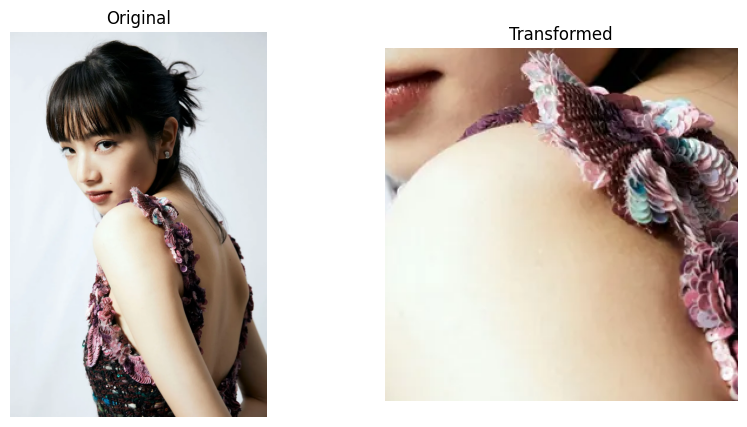

In [17]:
compare_images(image, tensor_to_pil(transformed_image))

## 2.3 Choice

In [18]:
train_dataset = MNIST(root="./data", train=True, transform=transform_v2)
test_dataset = MNIST(root="./data", train=False, transform=transform_v2)

# 3. DataLoader

In [19]:
from torch.utils.data import DataLoader

## 3.1 shuffle

In [20]:
train_dataloader_shuffled = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)
train_dataloader_non_shuffled = DataLoader(dataset=train_dataset, batch_size=1, shuffle=False)

### 3.1.1 original

In [21]:
for num in range(10):
    _, label = train_dataset.__getitem__(num)
    print(f"{num+1}번째 label: {label}")

1번째 label: 5
2번째 label: 0
3번째 label: 4
4번째 label: 1
5번째 label: 9
6번째 label: 2
7번째 label: 1
8번째 label: 3
9번째 label: 1
10번째 label: 4


### 3.1.2 non shuffled

In [22]:
data_iter = iter(train_dataloader_non_shuffled)

for num in range(10):
    _, label = next(data_iter)
    print(f"{num+1}번째 label: {label.item()}")

1번째 label: 5
2번째 label: 0
3번째 label: 4
4번째 label: 1
5번째 label: 9
6번째 label: 2
7번째 label: 1
8번째 label: 3
9번째 label: 1
10번째 label: 4


### 3.1.3 shuffled

In [23]:
data_iter = iter(train_dataloader_shuffled)

for num in range(10):
    _, label = next(data_iter)
    print(f"{num+1}번째 label: {label.item()}")

1번째 label: 7
2번째 label: 3
3번째 label: 2
4번째 label: 9
5번째 label: 7
6번째 label: 3
7번째 label: 2
8번째 label: 9
9번째 label: 2
10번째 label: 0


## 3.2 batch size

In [24]:
train_dataloader_batch_1 = DataLoader(dataset=train_dataset, batch_size=1)
train_dataloader_batch_64 = DataLoader(dataset=train_dataset, batch_size=64)

### 3.2.1 batch size: 1

In [25]:
data_iter = iter(train_dataloader_batch_1)


image, label = next(data_iter)
print(f"image: {image.shape}")
print(f"label: {len(label)}")

image: torch.Size([1, 1, 300, 300])
label: 1


### 3.2.1 batch size: 64

In [26]:
data_iter = iter(train_dataloader_batch_64)


image, label = next(data_iter)
print(f"image: {image.shape}")
print(f"label: {len(label)}")

image: torch.Size([64, 1, 300, 300])
label: 64


## 3.3 choice

In [27]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=False)

# 4. Model

In [28]:
import torch.nn as nn
from torch.utils.data import Subset
from torchvision.models.mobilenetv2 import mobilenet_v2, MobileNet_V2_Weights

In [29]:
transform_v2_4 = v2.Compose([
    v2.Grayscale(num_output_channels=3),
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=False),
])

test_dataset_4 = MNIST(root='./data', train=False, transform=transform_v2_4)
test_subset_4 = Subset(test_dataset_4, indices=range(1000))
test_loader_4 = DataLoader(test_subset_4, batch_size=64, shuffle=False)

def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test dataset: {accuracy:.2f}%')

## 4.1 [torchvision.models](https://pytorch.org/vision/0.20/models)

In [30]:
mobilenet_v2_model = mobilenet_v2()
mobilenet_v2_model.classifier[1] = torch.nn.Linear(mobilenet_v2_model.last_channel, 10)

print(f"mobilenet_v2_model의 파라미터 수: {sum(p.numel() for p in mobilenet_v2_model.parameters()):,}")
evaluate_model(mobilenet_v2_model, test_loader_4)
print(mobilenet_v2_model)

mobilenet_v2_model의 파라미터 수: 2,236,682
Accuracy of the model on the test dataset: 10.70%
MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16

### 4.1.1 load pre-trained weights

In [31]:
mobilenet_v2_model_pre_trained = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
mobilenet_v2_model_pre_trained.classifier[1] = torch.nn.Linear(mobilenet_v2_model_pre_trained.last_channel, 10)

print(f"mobilenet_v2_model_pre_trained의 파라미터 수: {sum(p.numel() for p in mobilenet_v2_model_pre_trained.parameters()):,}")
evaluate_model(mobilenet_v2_model_pre_trained, test_loader_4)

mobilenet_v2_model_pre_trained의 파라미터 수: 2,236,682
Accuracy of the model on the test dataset: 12.00%


### 4.1.2 save trained weight

In [32]:
torch.save(mobilenet_v2_model_pre_trained.state_dict(), "mobilenet_v2_mnist.pth")

## 4.2 [torch.nn.Module](https://pytorch.org/docs/2.5/)

In [33]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(300 * 300, 10)

    def forward(self, x):
        x = x.view(-1, 300 * 300 * 1)
        x = self.fc1(x)
        
        return x

In [34]:
simple_model = SimpleModel()

print(f"simple_model의 파라미터 수: {sum(p.numel() for p in simple_model.parameters()):,}")
print(simple_model)

simple_model의 파라미터 수: 900,010
SimpleModel(
  (fc1): Linear(in_features=90000, out_features=10, bias=True)
)


## 4.3 choice

In [35]:
model = SimpleModel()

# 5. Loss

In [36]:
import torch.nn as nn

In [37]:
logits = torch.tensor([[1.0, 2.0, 0.1], [0.5, 0.2, 1.5]])
labels = torch.tensor([1, 2])

## 5.1 [torch.nn](https://pytorch.org/docs/2.5/nn.html#loss-functions)

$$
\text{Loss} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \log \left( \frac{\exp(z_{i,c})}{\sum_{j=1}^{C} \exp(z_{i,j})} \right)
$$


In [38]:
criterion = nn.CrossEntropyLoss()

loss = criterion(logits, labels)
print(f"nn.CrossEntropyLoss: {loss.item()}")

nn.CrossEntropyLoss: 0.45598846673965454


## 5.2 custom

In [39]:
def custom_cross_entropy_loss(logits, labels):
    softmax_probs = torch.exp(logits) / torch.exp(logits).sum(dim=1, keepdim=True)
    
    log_probs = torch.log(softmax_probs)
    chosen_log_probs = log_probs[range(len(labels)), labels]
    
    loss = -chosen_log_probs.mean()

    return loss

loss = custom_cross_entropy_loss(logits, labels)
print(f"custom CrossEntropyLoss: {loss.item()}")

custom CrossEntropyLoss: 0.4559885263442993


## 5.3 choice

In [40]:
criterion = nn.CrossEntropyLoss()

# 6. Optimizer

In [41]:
import torch.optim as optim

## 6.1 [torch.optim](https://pytorch.org/docs/stable/optim.html)

In [42]:
optimizer = optim.SGD(model.parameters(), lr=0.00001)

## 6.2 choice

In [43]:
optimizer = optim.SGD(model.parameters(), lr=0.00001)

# 7. Train

## 7.1 basic

In [44]:
def train(model, train_loader, criterion, optimizer, epochs=1):
    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

train(model, train_dataloader, criterion, optimizer, epochs=5)

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 500: named symbol not found (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/5], Loss: 0.3090
Epoch [2/5], Loss: 0.4086
Epoch [3/5], Loss: 0.3449
Epoch [4/5], Loss: 0.2077
Epoch [5/5], Loss: 0.3066


## 7.2 [tensorboard](https://pytorch.org/docs/main/tensorboard.html)

In [45]:
from torch.utils.tensorboard import SummaryWriter

def train(model, train_loader, criterion, optimizer, epochs=1, log_dir="runs/train"):
    writer = SummaryWriter(log_dir)  # 텐서보드 작성자 생성
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            # 매 10번째 배치마다 텐서보드에 손실 기록
            if (i + 1) % 10 == 0:
                writer.add_scalar("Training Loss", running_loss / 10, epoch * len(train_loader) + i)
                running_loss = 0.0

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    writer.close()  # 텐서보드 작성자 닫기

# 함수 호출
train(model, train_dataloader, criterion, optimizer, epochs=5)

Epoch [1/5], Loss: 0.3776
Epoch [2/5], Loss: 0.5658
Epoch [3/5], Loss: 0.2189
Epoch [4/5], Loss: 0.2993
Epoch [5/5], Loss: 0.2501


In [46]:
torch.save(model.state_dict(), "simple_net.pth")

# 8. Evaluate

In [47]:
def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total:.2f}%')

model = SimpleModel()

## 8.1 non-trained

In [48]:
evaluate(model, test_dataloader)

Accuracy: 15.76%


## 8.2 trained

In [50]:
state_dict = torch.load("simple_net.pth")
model.load_state_dict(state_dict)

evaluate(model, test_dataloader)

/tmp/ipykernel_171222/1943516339.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("simple_net.pth")


Accuracy: 92.22%
